# Imports

In [282]:
import numpy as np
from skimage import io
from skimage.filters import gaussian
import pydicom
from pydicom import dcmread
from pydicom.data import get_testdata_file

# Parameters

In [283]:
# angle diff between iterations
EMITTER_STEP = 1/4
# n
DETECTOR_COUNT = 300
# I (deg)
DETECTOR_SPAN = 180

# input and output file
INPUT_PATH = "imgs/CT_ScoutView.jpg"
OUTPUT_PATH = "ct_output.jpg"

# Functions

In [284]:
def normalize_img(img):
    """values in range 0-1"""
    min_v = np.amin(img)
    max_v = np.amax(img)
    if min_v != max_v:
        return (img[:, :] - min_v) / (max_v - min_v)
    return img

In [285]:
def normalize_touched(img, touched):
    min_v = np.amin(img[touched])
    max_v = np.amax(img[touched])
    if min_v != max_v:
        return (img[:, :] - min_v) / (max_v - min_v)
    return img

In [286]:
def resize_to_square(img):
    size = int(np.ceil(np.max(img.shape) * np.sqrt(2)))
    # size = np.max(img.shape)
    size += 1 - size % 2
    square_img = np.zeros((size, size))
    dy, dx = (size - img.shape[0]) // 2, (size - img.shape[1]) // 2
    square_img[dy:(img.shape[0] + dy), dx:(img.shape[1] + dx)] = img
    return square_img, (dx, dy, size - img.shape[1] - dx, size - img.shape[0] - dy)

In [287]:
def trim_img(img, dx0, dy0, dx1, dy1):
    trimmed = np.empty((img.shape[0] - dy0 - dy1, img.shape[1] - dx0 - dx1))
    trimmed[:, :] = img[dy0:(dy0 + trimmed.shape[0]), dx0:(dx0 + trimmed.shape[1])]
    return trimmed

In [288]:
def load_img(path):
    img = io.imread(path, as_gray=True)
    img = normalize_img(img)
    return img

In [289]:
def show_img(img):
    io.imshow(img, cmap='gray')

In [290]:
def bresenham(x0, y0, x1, y1):
    """generator yielding tuples of xs and ys of pixels traversed on line from (x0, y0) to (x1, y1) (inclusive)"""
    def delta_and_sign(v0, v1):
        return (v1 - v0, 1) if v0 < v1 else (v0 - v1, -1)
    
    dx, x_sign = delta_and_sign(x0, x1)
    dy, y_sign = delta_and_sign(y0, y1)
    
    x, y = x0, y0
    yield x, y
    if dx > dy:
        ai = 2 * (dy - dx)
        bi = dy * 2
        d = bi - dx
        while x != x1:
            if d >= 0:
                y += y_sign
                d += ai
            else:
                d += bi;
            x += x_sign
            yield x, y
    else:
        ai = 2 * (dx - dy)
        bi = dx * 2
        d = bi - dy;
        while y != y1:
            if d >= 0:
                x += x_sign
                d += ai
            else:
                d += bi
            y += y_sign
            yield x, y

In [291]:
def bresenham_list(x0, y0, x1, y1):
    """list of points from bresenham generator"""
    return [*bresenham(x0, y0, x1, y1)]

In [292]:
def points_to_indices(points):
    """points to indices for np.array"""
    return tuple([*zip(*points)][::-1])

In [293]:
def mean_on_line(img, x0, y0, x1, y1):
    """mean of pixels on line from (x0, y0) to (x1, y1) (inclusive)"""
    return np.mean(img[points_to_indices(bresenham_list(x0, y0, x1, y1))])

In [294]:
def calc_radius(img):
    """assume img is already square"""
    r = img.shape[0] // 2
    return r

In [295]:
def rad_to_cart(cx, cy, r, angle):
    """radial to cartesian coordinates conversion, input angle in radians, output x and y truncated ints"""
    x = r * np.cos(angle) + cx
    y = r * np.sin(angle) + cy
    return int(x), int(y)

In [296]:
def emitter_angles(emitter_step, r):
    return np.arange(0, np.pi, emitter_step)

In [297]:
def detectors(r, emitter_angle, detector_count, detector_span):
    """generate detectors based on emitter coordinates, angles in radians"""
    detector_angle = emitter_angle + np.pi - detector_span / 2.0
    if detector_angle < 0:
        detector_angle += 2 * np.pi
    elif detector_angle >= 2 * np.pi:
        detector_angle -= 2 * np.pi
        
    angle_diff = detector_span / detector_count
    for i in range(detector_count):
        x, y = rad_to_cart(r, r, r, detector_angle)
        detector_angle += angle_diff
        yield x, y

In [298]:
def lines(r, emitter_angle, detector_count, detector_span):
    """generate lines between emitters and detectors (parallel)"""
    half_span = detector_span / 2.0
    emitter_from = emitter_angle + half_span
    emitter_to = emitter_from - detector_span
    detector_from = emitter_angle + np.pi - half_span
    detector_to = detector_from + detector_span
    
    emitter_angles = np.linspace(emitter_from, emitter_to, detector_count)
    detector_angles = np.linspace(detector_from, detector_to, detector_count)
    for em_angle, det_angle in zip(emitter_angles, detector_angles):
        ex, ey = rad_to_cart(r, r, r, em_angle)
        dx, dy = rad_to_cart(r, r, r, det_angle)
        yield ex, ey, dx, dy

In [299]:
def emitter_measurements(img, r, emitter_angle, detector_count, detector_span):
    #emitter_pos = rad_to_cart(r, r, r, emitter_angle)
    measurements = np.zeros(detector_count)
    #for i, detector_pos in enumerate(detectors(r, emitter_angle, detector_count, detector_span)):
    #    measurements[i] = mean_on_line(img, *emitter_pos, *detector_pos)
    for i, line in enumerate(lines(r, emitter_angle, detector_count, detector_span)):
        measurements[i] = mean_on_line(img, *line)
    return measurements

In [300]:
def img_to_sinogram(img, emitter_step, r, detector_count, detector_span):
    angles = emitter_angles(emitter_step, r)
    sinogram = np.empty((len(angles), detector_count))
    
    for i, emitter_angle in enumerate(angles):
        sinogram[i, :] = emitter_measurements(img, r, emitter_angle, detector_count, detector_span)
    return sinogram

In [301]:
def emitter_onto_img(img, touched, measurments, r, emitter_angle, detector_count, detector_span):
    #emitter_pos = rad_to_cart(r, r, r, emitter_angle)
    #for i, detector_pos in enumerate(detectors(r, emitter_angle, detector_count, detector_span)):
        #img[points_to_indices(bresenham_list(*emitter_pos, *detector_pos))] += measurments[i]
    for i, line in enumerate(lines(r, emitter_angle, detector_count, detector_span)):
        points = points_to_indices(bresenham_list(*line))
        img[points] += measurments[i]
        touched[points] = True

In [302]:
def sinogram_to_img(sinogram, emitter_step, r, detector_count, detector_span):
    img = np.zeros((2 * r + 1, 2 * r + 1))
    touched = img == 0
    
    for i, emitter_angle in enumerate(emitter_angles(emitter_step, r)):
        emitter_onto_img(img, touched, sinogram[i, :], r, emitter_angle, detector_count, detector_span)
    return normalize_touched(img, touched)

In [303]:
def get_mask(n):
    mask = np.arange(n, dtype=float) - n // 2
    mask[mask % 2 == 0] = 0
    mask[mask % 2 != 0] = (-4 / np.pi ** 2) / (mask[mask % 2 != 0] ** 2)
    mask[n // 2] = 1
    return mask

In [304]:
def convolve(img, mask):
    output = np.empty(img.shape)
    for i in range(img.shape[0]):
        output[i, :] = np.convolve(img[i, :], mask, mode='same')
    return output

# App

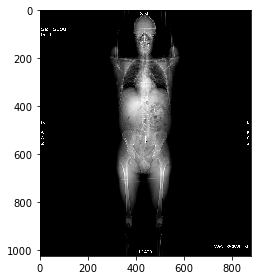

In [305]:
# load img
input_image = load_img(INPUT_PATH)
show_img(input_image)

square_img, offset = resize_to_square(input_image)

# calculate params
r = calc_radius(square_img)
emitter_step_rad = np.deg2rad(EMITTER_STEP)
detector_span_rad = np.deg2rad(DETECTOR_SPAN)

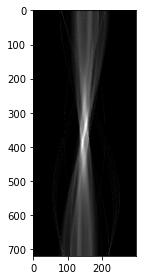

In [306]:
# get sinogram
sinogram = img_to_sinogram(square_img, emitter_step_rad, r, DETECTOR_COUNT, detector_span_rad)
show_img(normalize_img(sinogram))

In [307]:
# sinogram = normalize_img(sinogram)
# mask = get_mask(25)
sinogram = convolve(sinogram, get_mask(11)) #convolve(sinogram, mask)

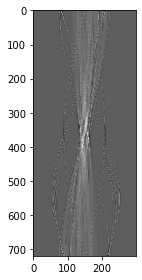

In [308]:
show_img(normalize_img(sinogram))

In [309]:
output_img = sinogram_to_img(sinogram, emitter_step_rad, r, DETECTOR_COUNT, detector_span_rad)

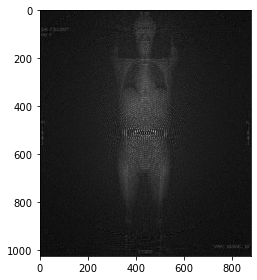

In [310]:
trimmed_img = trim_img(output_img, *offset)
show_img(trimmed_img)

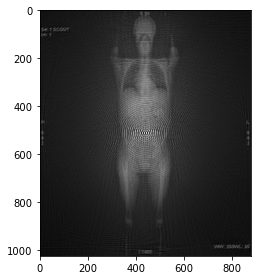

In [311]:
end_img = gaussian(trimmed_img)
show_img(normalize_img(end_img))

# DICOM

In [312]:
def write_dicom(image, name, pesel, comment, sex, birthDaten, file_name):
    filename = get_testdata_file("CT_small.dcm")
    ds = pydicom.dcmread(filename)
    image2 = np.asarray(image*255, dtype=np.uint16)
    ds.Rows = image2.shape[0]
    ds.Columns = image2.shape[1]
    ds.PixelData = image2.tobytes()
    ds.PatientName = name
    ds.PatientID = pesel
    ds.InstitutionName = 'Politechnika Poznanska'
    ds.Manufacturer = 'Politechnika Poznanska'
    ds.PatientSex = sex
    ds.PatientBirthDate = birthDate
    dt = datetime.datetime.now()
    ds.StudyDate = dt.strftime('%Y%m%d')
    timeStr = dt.strftime('%H%M%S.%d')
    ds.StudyTime = timeStr
    ds.AdditionalPatientHistory = comment
    ds.save_as(str(file_name))

In [313]:
def read_dicom(filename):
    ds = pydicom.dcmread(filename)
    return ds

In [314]:
def show_dicom(ds):
    print(f"Patient's Name...: {ds.get('PatientName','-')}")
    print(f"Patient ID.......: {ds.get('PatientID','-')}")
    print(f"Modality.........: {ds.get('Modality','-')}")
    print(f"Study Date.......: {ds.get('StudyDate','-')}")
    print(f"Image size.......: {ds.get('Rows','-')} x {ds.get('Columns','-')}")
    #print(f"Pixel Spacing....: {ds.PixelSpacing}")
    show_img(normalize_img(ds.pixel_array))

In [315]:
name = 'Janina Nowak'
comment = 'Przykladowy komentarz'
sex = 'F'
pesel = '99999999999'
birthDate = '19900123'

In [316]:
filename = "Tomograf_DICOM2.dcm"

In [317]:
write_dicom(end_img, name, pesel, comment, sex, birthDate, filename)
ds = read_dicom(filename)

Patient's Name...: Janina Nowak
Patient ID.......: 99999999999
Modality.........: CT
Study Date.......: 20210315
Image size.......: 1024 x 880


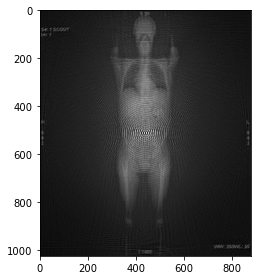

In [318]:
show_dicom(ds)